## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

In [2]:
### Download the universal_tagset dataset if it is not available. If already present the command will return 'True'

nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/nirbhay/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
#First three sentences in the dataset
print(nltk_data[:3])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [5]:
#set the random seed
random.seed(1234)

#Divide the data into training and test sets
train_set, test_set = train_test_split(nltk_data,train_size=0.95, test_size=0.05,random_state = 101)

In [6]:
#Get the length of training and test sets
print("Length of training set: ",len(train_set))
print("Length of test set: ",len(test_set))

Length of training set:  3718
Length of test set:  196


In [7]:
# Getting list of tagged words in training set
train_tagged_words = [tup for sent in train_set for tup in sent]
#Get the length of the total tagged words in training set
len(train_tagged_words)

95547

In [8]:
# View the first 10 tokens/words in the training set
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*']

In [9]:
# check some of the tagged words.
train_tagged_words[1:5]

[('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ')]

In [10]:
# Get the total unique words in the training set
vocab = set(tokens)
print(len(vocab))

12100


In [11]:
# number of pos tags in the training corpus
tags = set([pair[1] for pair in train_tagged_words])
print(len(tags))
print(tags)

12
{'PRON', 'ADP', 'DET', 'ADV', 'X', 'VERB', 'PRT', 'CONJ', 'NUM', 'ADJ', 'NOUN', '.'}


### Build the vanilla Viterbi based POS tagger

We will now build a _Vanilla Viterbi_ POS tagger and assess the accuracy of this tagger.

This will be the baseline for our future models. We will try to improve the Viterbi tagger using the following approaches:

 - _Viterbi Modification-1_ : We consider the transition probabilities of the unknown words. Then modify the transition probabilities using a weighted tag occurence in the training set.
 - _Viterbi Modification-2_ : We use a rule based tagger on unkown words. Then modify the transition probability if the rule based tagger returns a default Noun(NN) tag.

#### Using Hidden Markov Models to Genarate POS tagger

In HMMs, the task is: Given a sequence of words, assign the most probable tag to the word.

The formula for this is:
 - **P(tag/word) = P(word/tag). P(tag) / P(word)**
 
We have to calculate the _Emission Probability_, given by **P(word/tag)**, and the _Transition Probability_, given by **P(tag)**.


In [12]:
# compute Emission Probability of a word for a given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# compute tag given previous tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [14]:
# Create numpy array of no of pos tags by total vocabulary
t = len(tags)
v = len(vocab)
w_given_t = np.zeros((t, v))

In [15]:
# creating t x t (pos tags x pos tags)transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [16]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
tags_df

,PRON,ADP,DET,ADV,X,VERB,PRT,CONJ,NUM,ADJ,NOUN,.
PRON,0.007657,0.022971,0.009954,0.034074,0.089969,0.485452,0.013017,0.005360,0.006508,0.073124,0.210949,0.040965
ADP,0.070031,0.016893,0.324709,0.014006,0.034427,0.008340,0.001390,0.000962,0.062226,0.107024,0.320967,0.039025
DET,0.003744,0.009540,0.005676,0.012438,0.045405,0.039850,0.000242,0.000483,0.022220,0.204323,0.638087,0.017993
ADV,0.014906,0.118582,0.069891,0.080490,0.023186,0.343491,0.014243,0.006956,0.030474,0.129182,0.031467,0.137131
X,0.055538,0.142584,0.054742,0.024984,0.076384,0.203851,0.185232,0.010662,0.002864,0.017187,0.062381,0.163590
VERB,0.035786,0.092022,0.134392,0.081952,0.217506,0.169249,0.030674,0.005577,0.022851,0.064988,0.110070,0.034934
PRT,0.017792,0.020099,0.097858,0.010214,0.013509,0.405272,0.001647,0.002306,0.056672,0.083031,0.247776,0.043822
CONJ,0.058113,0.052534,0.121339,0.055323,0.008833,0.156671,0.004649,0.000465,0.039981,0.118085,0.349140,0.034868
NUM,0.001489,0.036033,0.003276,0.002978,0.210542,0.018761,0.026504,0.013699,0.184932,0.034247,0.350208,0.117332
ADJ,0.000330,0.078267,0.004943,0.004778,0.021091,0.011699,0.010710,0.016971,0.021256,0.066403,0.699621,0.063931


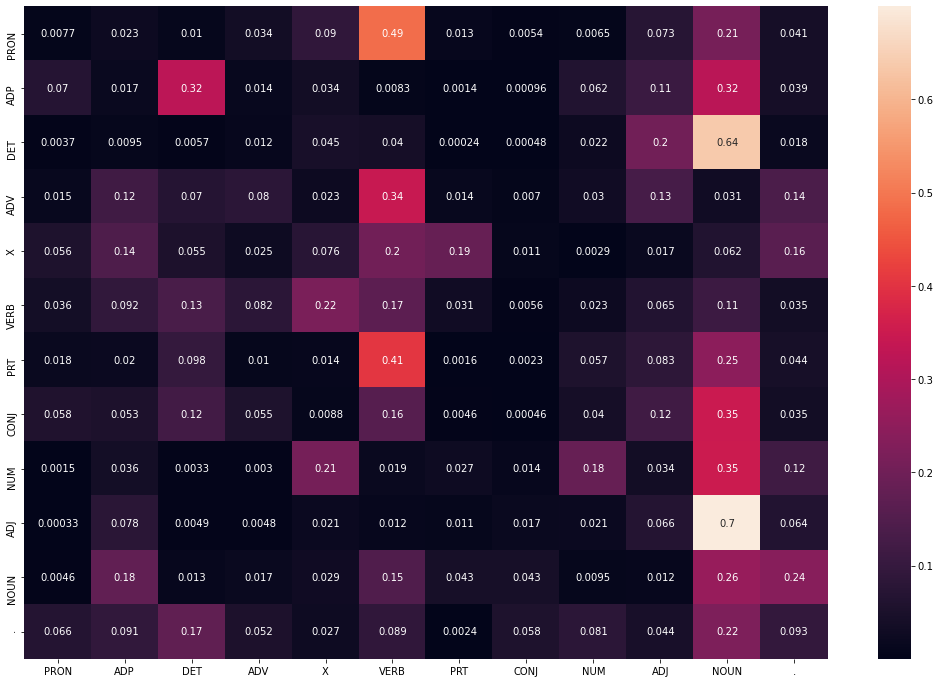

In [17]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df, annot=True)
plt.show()

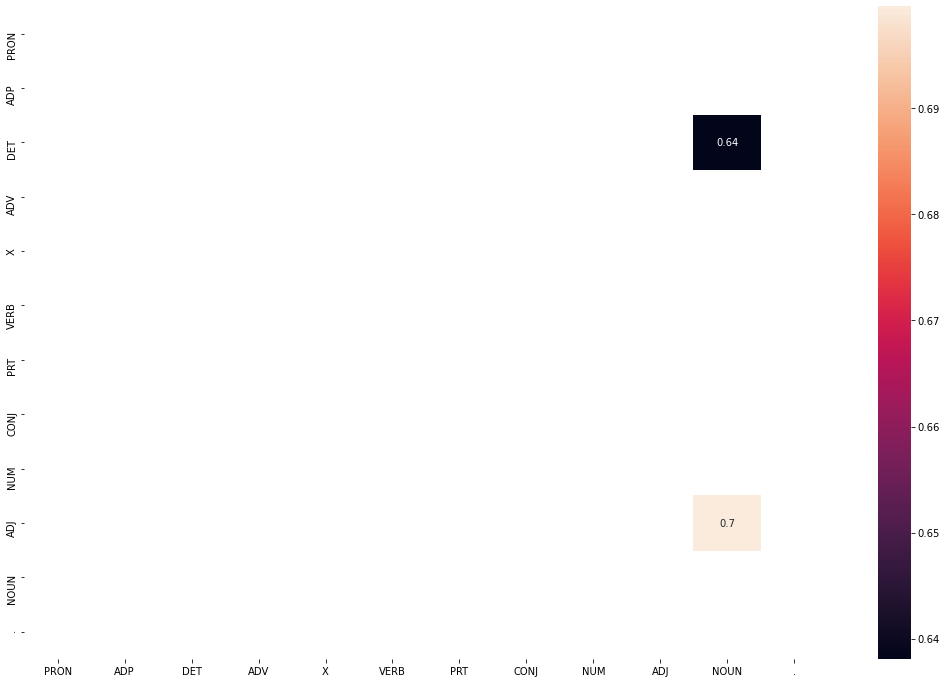

In [18]:

# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent, annot=True)
plt.show()

### Observation

From the above heatmaps we can see that:
    
    - ADJ-Noun combinations are the highest occuring
    - DET-NOUN combinations occur the 2nd most frequently in the training set

In [19]:
#Get the total length of tagged words in training corpus
len(train_tagged_words)

95547

#### Viterbi Algorithm

The steps are as follows:

1. Given a sequence of words
2. Iterate through the sequence
3. For each word (starting from first word in sequence):
    1. Calculate the product of emission probabilties and transition probabilties for all possible tags.
4. Assign the tag which has maximum probability obtained in step 3 .
5. Move to the next word in sequence to repeat steps 3 and 4 above.

In [20]:
# Building Vanilla Viterbi algorithm
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [21]:
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [22]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))


Time taken in seconds:  9.93


In [23]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',round((accuracy*100),2))

Vanilla Viterbi Algorithm Accuracy:  88.5


In [24]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('Contra', 'PRON'), ('Contra', 'NOUN')),
 (('command', 'VERB'), ('command', 'NOUN')),
 (('Honduras', 'PRON'), ('Honduras', 'NOUN')),
 (('Sandinista', 'PRON'), ('Sandinista', 'NOUN')),
 (('offensive', 'PRON'), ('offensive', 'NOUN')),
 (('rebel', 'PRON'), ('rebel', 'NOUN')),
 (('forces', 'VERB'), ('forces', 'NOUN')),
 (('Bucking', 'PRON'), ('Bucking', 'VERB')),
 (('drew', 'PRON'), ('drew', 'VERB')),
 (('Eveready', 'PRON'), ('Eveready', 'NOUN')),
 (('*T*-252', 'PRON'), ('*T*-252', 'X')),
 (('complaining', 'PRON'), ('complaining', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT'))]

### Observation:

We notice above that the accuracy of our vanilla viterbi model is **88.5%**

We will use this as a baseline for our modified Viterbi models. 


### Solve the problem of unknown words

We will now modify our viterbi algorithm to tackle the problem of unknown words. This will be done as follows:

- **Viterbi Modification-1** : We consider the transition probabilities of the unknown words. Then modify the transition probabilities using a weighted tag occurence in the training set.

In [25]:
# use transition probability of tags when emission probability is zero (in case of unknown words)

def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [26]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round((difference),2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',round((accuracy*100),2))

Time taken in seconds:  9.26
Modified Viterbi_1 Accuracy:  94.69


### Observation:

We notice that there is a high jump in the accuracy of the model.

Let us try to immprove it by adding tag occurance probability weights to the transition probabilities of the tags.


In [27]:
# lets create a list containing tuples of POS tags and POS tag occurance probability, based on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('PRON', 0.0273373313657153),
 ('ADP', 0.0978889970381069),
 ('DET', 0.08666938784053921),
 ('ADV', 0.031597015081582885),
 ('X', 0.06576867928872701),
 ('VERB', 0.1351167488251855),
 ('PRT', 0.03176447193527793),
 ('CONJ', 0.02251248076862696),
 ('NUM', 0.035145007169246546),
 ('ADJ', 0.06351847781719991),
 ('NOUN', 0.2862674913916711),
 ('.', 0.11641391147812072)]

In [28]:
def Viterbi_1_tag_probs(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [29]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1_tag_probs(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 with tag probabilities accuracy: ',round((accuracy*100),2))

Time taken in seconds:  9.21
Modified Viterbi_1 with tag probabilities accuracy:  95.58


In [30]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('Sandinista', 'VERB'), ('Sandinista', 'NOUN')),
 (('Eveready', 'VERB'), ('Eveready', 'NOUN')),
 (('*T*-252', 'VERB'), ('*T*-252', 'X')),
 (('up', 'ADV'), ('up', 'PRT'))]

### Observation

We notice that our accuracy went further up. We also have a lesser number of incorrectly tagged words.

Words that have been correctly tagged, as compared to Vanilla Viterbi are:

- 'Contra' correctly tagged as NOUN
- 'Honduras' correctly tagged as NOUN

Let us try our 2nd modification and see if that increases the probability of the model or not.

- _Viterbi Modification-2_ : We use a rule based tagger on unkown words. Then modify the transition probability if the rule based tagger returns a default Noun(NN) tag.

In [31]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [32]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [33]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Viterbi_2 accuracy: ',round((accuracy*100),2))

Time taken in seconds:  9.3
Viterbi_2 accuracy:  97.35


In [34]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('drew', 'NOUN'), ('drew', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT'))]

### Observation

Our overall accuracy went further up to 97.35%, however we still have a few incorrectly tagged words. Let us make the default noun management modification to our viterbi algorithm and see.

In [35]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [36]:
# modified Viterbi with default noun mamagement
def Viterbi_2_mod(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [37]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2_mod(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 accuracy: ',round((accuracy*100),2))

Time taken in seconds:  9.18
Modified Viterbi_2 accuracy:  98.23


In [38]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')), (('up', 'ADV'), ('up', 'PRT'))]

### Observation

Compared to Vanilla Viterby we have tagged even more words correctly. Now we only have the following words incorrectly tagged:
    - command & up
    
Our overall model accuracy is 98.23%. Therefore we will be using this as our final tagging model.

# Evaluating tagging accuracy

First we will evaluate the accuracy on the test set and then on the sample tests sentences provided.

In [39]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [42]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',round((accuracy*100),2))

Time taken in seconds:  407.42
Vanilla Viterbi Algorithm Accuracy:  90.89


In [43]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round((difference),2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',round((accuracy*100),2))

Time taken in seconds:  407.67
Modified Viterbi_1 Accuracy:  94.03


In [44]:
# tagging the test sentences with Viterbi modified with tag probabilities
start = time.time()
tagged_seq = Viterbi_1_tag_probs(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 with tag probabilities accuracy: ',round((accuracy*100),2))

Time taken in seconds:  396.95
Modified Viterbi_1 with tag probabilities accuracy:  94.46


In [45]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2_mod(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", round(difference,2))

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 accuracy: ',round((accuracy*100),2))

Time taken in seconds:  399.13
Modified Viterbi_2 accuracy:  95.44


### Observation

As you can see that even on the test set the modified Viterbi_2_mod algorithm gives us the highest accuracy. 

### Testing on test_sentences file

In [46]:
#Read the text file

lines=[]
f = codecs.open("Test_sentences.txt", encoding='utf-8')
for line in f:
    print(line)
    lines.append(line)

Android is a mobile operating system developed by Google.

Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.

Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.

Twitter is an online news and social networking service on which users post and interact with messages known as tweets.

Before entering politics, Donald Trump was a domineering businessman and a television personality.

The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.

This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.

Show me the cheapest round trips from Dallas to Atlanta

I would like to see flights from Denver to Philadelphia.

Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.

NASA invited social media users to experience the launch of ICESAT-2 Satelli

In [47]:
sample_test_sent = [sent.rstrip() for sent in lines if sent.rstrip()!='']

In [48]:
sample_test_tokenized_sents = [word_tokenize(sent) for sent in sample_test_sent]
sample_test_corpus_pos_tags = nltk.pos_tag_sents(sample_test_tokenized_sents, tagset = 'universal')
sample_test_corpus_pos_tags

[[('Android', 'NOUN'),
  ('is', 'VERB'),
  ('a', 'DET'),
  ('mobile', 'ADJ'),
  ('operating', 'NOUN'),
  ('system', 'NOUN'),
  ('developed', 'VERB'),
  ('by', 'ADP'),
  ('Google', 'NOUN'),
  ('.', '.')],
 [('Android', 'NOUN'),
  ('has', 'VERB'),
  ('been', 'VERB'),
  ('the', 'DET'),
  ('best-selling', 'ADJ'),
  ('OS', 'NOUN'),
  ('worldwide', 'NOUN'),
  ('on', 'ADP'),
  ('smartphones', 'NOUN'),
  ('since', 'ADP'),
  ('2011', 'NUM'),
  ('and', 'CONJ'),
  ('on', 'ADP'),
  ('tablets', 'NOUN'),
  ('since', 'ADP'),
  ('2013', 'NUM'),
  ('.', '.')],
 [('Google', 'NOUN'),
  ('and', 'CONJ'),
  ('Twitter', 'NOUN'),
  ('made', 'VERB'),
  ('a', 'DET'),
  ('deal', 'NOUN'),
  ('in', 'ADP'),
  ('2015', 'NUM'),
  ('that', 'DET'),
  ('gave', 'VERB'),
  ('Google', 'NOUN'),
  ('access', 'NOUN'),
  ('to', 'PRT'),
  ('Twitter', 'NOUN'),
  ("'s", 'PRT'),
  ('firehose', 'NOUN'),
  ('.', '.')],
 [('Twitter', 'NOUN'),
  ('is', 'VERB'),
  ('an', 'DET'),
  ('online', 'ADJ'),
  ('news', 'NOUN'),
  ('and', 'CONJ'

In [49]:
# list of untagged words from the sample test data provided
sample_test_tagged_words = [tup[0] for sent in sample_test_corpus_pos_tags for tup in sent]


# list of tagged words
sample_test_test_run_base = [tup for sent in sample_test_corpus_pos_tags for tup in sent]

sample_test_tagged_words


['Android',
 'is',
 'a',
 'mobile',
 'operating',
 'system',
 'developed',
 'by',
 'Google',
 '.',
 'Android',
 'has',
 'been',
 'the',
 'best-selling',
 'OS',
 'worldwide',
 'on',
 'smartphones',
 'since',
 '2011',
 'and',
 'on',
 'tablets',
 'since',
 '2013',
 '.',
 'Google',
 'and',
 'Twitter',
 'made',
 'a',
 'deal',
 'in',
 '2015',
 'that',
 'gave',
 'Google',
 'access',
 'to',
 'Twitter',
 "'s",
 'firehose',
 '.',
 'Twitter',
 'is',
 'an',
 'online',
 'news',
 'and',
 'social',
 'networking',
 'service',
 'on',
 'which',
 'users',
 'post',
 'and',
 'interact',
 'with',
 'messages',
 'known',
 'as',
 'tweets',
 '.',
 'Before',
 'entering',
 'politics',
 ',',
 'Donald',
 'Trump',
 'was',
 'a',
 'domineering',
 'businessman',
 'and',
 'a',
 'television',
 'personality',
 '.',
 'The',
 '2018',
 'FIFA',
 'World',
 'Cup',
 'is',
 'the',
 '21st',
 'FIFA',
 'World',
 'Cup',
 ',',
 'an',
 'international',
 'football',
 'tournament',
 'contested',
 'once',
 'every',
 'four',
 'years',
 '.'

In [50]:
# tagging the test sentences
sample_test_tagged_seq = Viterbi(sample_test_tagged_words)

# Let's check the accuracy of the vanilla viterbi algorithm
sample_test_check = [i for i, j in zip(sample_test_tagged_seq, sample_test_test_run_base) if i == j]

vanilla_viterbi_accuracy_on_sample_test_data = len(sample_test_check)/len(sample_test_tagged_seq)

print("The accuracy of the Vanilla Viterbi Algorithm on the sample test data is -", round((vanilla_viterbi_accuracy_on_sample_test_data*100),2))

The accuracy of the Vanilla Viterbi Algorithm on the sample test data is - 75.14


In [51]:
### Assessing words tagged by vanilla viterbi 
sample_test_tagged_seq

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRON'),
 ('.', '.'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRON'),
 ('.', '.'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRON'),
 ("'s", 'VERB'),
 ('firehose', 'PRON'),
 ('.', '.'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


In [52]:
# tagging the test sentences using modified Viterbi
sample_test_unknown_word_tagged_seq = Viterbi_1_tag_probs(sample_test_tagged_words)

# accuracy
sample_test_unknown_word_check = [i for i, j in zip(sample_test_unknown_word_tagged_seq, sample_test_test_run_base) if i == j]

sample_test_optimized_viterbi_accuracy = len(sample_test_unknown_word_check)/len(sample_test_unknown_word_tagged_seq)

print("The accuracy of the Modified Viterbi with Tag Probabilities on the sample test data is -", round((sample_test_optimized_viterbi_accuracy*100),2))

The accuracy of the Modified Viterbi with Tag Probabilities on the sample test data is - 90.61


In [53]:
### Assessing words tagged by Viterbi_1 with Tag Probabilities  
sample_test_unknown_word_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

In [54]:
# tagging the test sentences
sample_test_viterbi_2_mod = Viterbi_2_mod(sample_test_tagged_words)

# accuracy
sample_test_viterbi_2_mod_check = [i for i, j in zip(sample_test_viterbi_2_mod, sample_test_test_run_base) if i == j]

sample_test_viterbi_2_mod_accuracy = len(sample_test_viterbi_2_mod_check)/len(sample_test_viterbi_2_mod)

print("The accuracy of the Modified Viterbi 2 tagger on the sample test data is -", round((sample_test_viterbi_2_mod_accuracy*100),2))

The accuracy of the Modified Viterbi 2 tagger on the sample test data is - 92.27


In [55]:
### Assessing words tagged by Viterbi_2 with Rule Based Tagging and Default Noun probability assessment
sample_test_viterbi_2_mod

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NUM'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

# Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [56]:
### Let us plot the accuracies for the various models to see a visual comparison

acccuracy_data = [['Vanilla Viterbi', vanilla_viterbi_accuracy_on_sample_test_data*100], 
                  ['Modified Viterbi with Tag Probabilities', sample_test_optimized_viterbi_accuracy*100],
                  ['Modified Viterbi with Rule Based Tagger', sample_test_viterbi_2_mod_accuracy*100]]

acccuracy_data_df = pd.DataFrame(acccuracy_data, columns = ['Tagging_Algorithm', 'Tagging_Accuracy'])

acccuracy_data_df.set_index('Tagging_Algorithm', drop = True, inplace = True)

acccuracy_data_df

,Tagging_Accuracy
Tagging_Algorithm,
Vanilla Viterbi,75.138122
Modified Viterbi with Tag Probabilities,90.607735
Modified Viterbi with Rule Based Tagger,92.265193


/home/nirbhay/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='Tagging_Algorithm'>

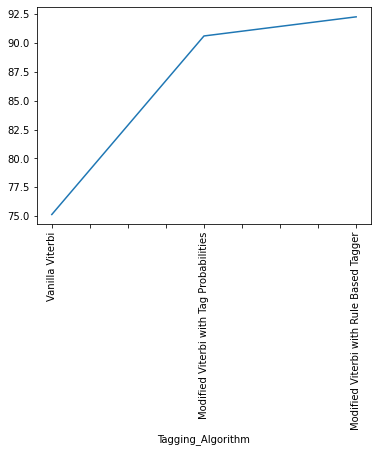

In [57]:
acccuracy_data_df.plot.line(rot = 90, legend = False)

### Observation

As you can see from the graph above:

- Modified rule based taggers have given us  higher accuracies
- The Modified Viterbi tagger with Rule Based Tagging and Default Noun management outperforms all other taggers in both test sets and on actual data. 

- The accuracy of the sample data set for the Vanilla Viterbi Algorithm is 75.13% 
- The accuracy of the sample data set for the Modified Viterbi 2 Algortihm is 92.27%

This difference shows a clear 18.3% accuracy improvement between the two models. 

# List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

There are multiple cases where the words were incorrectly classified. Some of them are listed below:

| Word | Vanilla Viterbi Tag | Modified Viterbi Tag |
| :- | -: | :-: |
| Android | PRON | NOUN |
| Google | PRON | NOUN |
| OS | PRON | NOUN |
| arriving | PRON | VERB |
| 2011 | PRON | NUM |
| 2013 | PRON | NUM |
| Satellite | PRON | NOUN |


# END OF FILE